In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
deepmd_jax_path = '../'           # Path to deepmd_jax package; change if you run this script at a different directory
precision       = 'default'       # 'default'(fp32), 'low'(tf32), 'high'(fp64)
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, grad, value_and_grad
import jax, sys, os, datetime, pickle
import flax.linen as nn
from time import time
import matplotlib.pyplot as plt
from functools import partial
sys.path.append(os.path.abspath(deepmd_jax_path))
from deepmd_jax.data import DPDataset
from deepmd_jax.dpmodel import DPModel
from deepmd_jax.utils import get_p3mlr, get_p3mlr_grid_size
if precision == 'default':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == 'high':
    jax.config.update('jax_enable_x64', True)
np.set_printoptions(precision=4, suppress=True)
print('# Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
# Program start at 2023-11-18 10:29:56 on device: [cuda(id=0)]


In [13]:
# Evaluating energy/force model; plot parity plot for force and energy
model_path       = 'trained_models/dpmp_polaron_full_1.pkl'
data_paths       = ['data/water_128_shifted']
# data_paths       = ['/pscratch/sd/r/ruiqig/polaron_cp2k/aimd/polaron_full_val']
test_batch_size  = 8
#############################################
with open(model_path, 'rb') as file:
    m = pickle.load(file)
model, variables = m['model'], m['variables']
dataset = DPDataset(data_paths, ['coord', 'box', 'force', 'energy'])
dataset.compute_lattice_candidate(model.params['rcut'])
force_true, force_pred, energy_true, energy_pred = [], [], [], []
e_and_f = jit(vmap(model.energy_and_force, in_axes=(None,0,0,None)), static_argnums=(3,))
dataset.pointer = 0
for i in range(dataset.nframes//test_batch_size):
    batch, type_idx, lattice_args = dataset.get_batch(test_batch_size)
    static_args = nn.FrozenDict({'type_idx':type_idx, 'lattice': lattice_args})
    force_true.append(batch['force'])
    energy_true.append(batch['energy'])
    e, f = e_and_f(variables, batch['coord'], batch['box'], static_args)
    force_pred.append(np.array(f))
    energy_pred.append(np.array(e))
force_true = np.concatenate(force_true, axis=0)
force_pred = np.concatenate(force_pred, axis=0)
energy_true = np.concatenate(energy_true, axis=0)
energy_pred = np.concatenate(energy_pred, axis=0)
force_err = force_true - force_pred
energy_err = (energy_true - energy_pred)
print('Mean force error = %.4f' % (force_err**2).mean()**0.5)
print('Mean energy error = %.4f, Mean energy shift = %.4f' % (energy_err.std(), energy_err.mean()))
# plt.plot(force_true.flatten(), force_pred.flatten(), '.') # parity plot for force
plt.figure()
plt.plot(np.abs(force_err).max(1).flatten(), '.') # max error for each atom's force
plt.figure()
plt.plot(energy_true, energy_pred, '.') # parity plot for energy

# Dataset loaded: 7797 frames/384 atoms. Path: 
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/water_128_shifted'
# Lattice vectors for neighbor images: Max 1 out of 1 condidates.


KeyboardInterrupt: 

In [78]:
# from deepmd_jax.utils import embedding_net, sr
from scipy.interpolate import PPoly, BPoly
model_path       = 'trained_models/dp_polaron_1.pkl'
with open(model_path, 'rb') as file:
    m = pickle.load(file)
model, variables = m['model'], m['variables']
embed = embedding_net(model.params['embed_widths'])
var = {'params': variables['params']['embedding_net_0']}
Ninterval = 256
srmin, srmax = -2, 4
r = np.linspace(srmin, srmax, Ninterval+1)
# enable 64 bit
jax.config.update("jax_enable_x64", True)
f0 = embed.apply(var, r[:,None])
f1 = vmap(jax.jacfwd(lambda x: embed.apply(var, x[None])))(r)
f2 = vmap(jax.jacfwd(jax.jacfwd(lambda x: embed.apply(var, x[None]))))(r)
f0.shape, f1.shape, f2.shape
poly = PPoly.from_bernstein_basis(BPoly.from_derivatives(r, np.stack([f0,f1,f2], axis=1), orders=None))
jax.config.update("jax_enable_x64", False)
poly_coeff = jnp.array(poly.c.transpose(1,0,2))
print(poly_coeff.shape)
def apply(r):
    r = r - srmin
    idx = (r * (Ninterval/(srmax-srmin))).astype(int) 
    r0 = (r - (idx*((srmax-srmin)/Ninterval)))[...,None]
    coeff = poly_coeff[idx]
    return sum([coeff[...,i,:]*r0**(5-i) for i in range(6)])
    # return vmap(vmap(jnp.polyval))(coeff, r0[...,0])

(256, 6, 64)


In [77]:
jax.config.update("jax_enable_x64", False)
jax.config.read('jax_enable_x64')

False

In [73]:
[net for net in variables['params'] if 'embed' in net and variables['params'][net]['Dense_0']['kernel'].shape[0] == 1]
    

['embedding_net_0', 'embedding_net_1', 'embedding_net_2', 'embedding_net_3']

In [74]:
np.stack([[1,2], [0.1, 0.3], axis=1])

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2020005598.py, line 1)

In [64]:
variables['compress_var'] = 1

In [67]:
type(variables)

dict

In [60]:
embed.apply({'compress_var': {'rmin': 1.}}, 3., compress=True)

2.0

In [92]:
r = np.linspace(srmin, srmax*(1-1e-6), (Ninterval+1)*10)
err0 = jnp.abs(apply(r) - embed.apply(var, r[...,None]))
err1 = jnp.abs(vmap(jax.jacfwd(lambda x: apply(x)))(r) - vmap(jax.jacfwd(lambda x: embed.apply(var, x[...,None])))(r))
err2 = jnp.abs(vmap(jax.jacfwd(jax.jacfwd(lambda x: apply(x))))(r) - vmap(jax.jacfwd(jax.jacfwd(lambda x: embed.apply(var, x[...,None]))))(r))
relerr0 = err0 / (jnp.abs(embed.apply(var, r[...,None])) + 1e-3)
relerr1 = err1 / (jnp.abs(vmap(jax.jacfwd(lambda x: embed.apply(var, x[...,None])))(r)) + 1e-3)
relerr2 = err2 / (jnp.abs(vmap(jax.jacfwd(jax.jacfwd(lambda x: embed.apply(var, x[...,None]))))(r)) + 1e-3)
print(err0.max(), err1.max(), err2.max())
print(err0.mean(), err1.mean(), err2.mean())

2.297759e-05 0.0033893585 0.99990845
1.1748139e-07 9.88543e-07 0.00017447186


In [43]:
from time import time
r = jnp.array(np.random.uniform(srmin, srmax, (16384, 128)))
def test1(r):
    return jax.lax.fori_loop(0, 1000, lambda i,r: apply(r).sum()*1e-16 + r, r).sum()
def test2(r):
    return jax.lax.fori_loop(0, 1000, lambda i,r: embed.apply(var, r[...,None]).sum()*1e-16 + r, r)
def test1g(r):
    g = grad(lambda r: apply(r).sum())
    return jax.lax.fori_loop(0, 1000, lambda i,r: g(r)*1e-16 + r, r).sum()
def test2g(r):
    g = jax.grad(lambda r: embed.apply(var, r[...,None]).sum())
    return jax.lax.fori_loop(0, 1000, lambda i,r: g(r)*1e-16 + r, r).sum()
for f in [jit(test1), jit(test1g)]:
    for i in range(5):
        tic = time()
        f(r).block_until_ready()
        print(time()-tic)
# for i in range(4):
#     tic = time()
#     jax.lax.fori_loop(0, 1000, lambda i,r: apply(r).sum()*1e-16 + r, r).sum().block_until_ready()
#     print(time()-tic)
# g = grad(lambda r: apply(r).sum())
# for i in range(4):
#     tic = time()
#     jax.lax.fori_loop(0, 1000, lambda i,r: g(r)*1e-16 + r, r).sum().block_until_ready()
#     print(time()-tic)

0.8909289836883545
0.585472583770752
0.5782065391540527
0.5841357707977295
0.5788934230804443
1.1827938556671143
1.0515358448028564
1.0526890754699707
1.053053379058838
1.0535173416137695


In [16]:
np.divmod(3., 2., dtype=int, casting='unsafe')

(1, 1)

In [44]:
# convert energy-force dataset to short range dataset; Used in DPLR
# source datasets should have the same type index; if not, run the code for each type index
source_paths       = ['data/chunyi_dplr/data/energy_force_data/data/data' + str(i) for i in range(1,46)] \
                   + ['data/chunyi_dplr/data/energy_force_data/data/data_ex' + str(i) for i in range(1,7)]
target_path        = 'data/chunyi_dplr/data/energy_force_data/data_sr'
wannier_model_path = 'trained_models/dw_chunyidplr_1.pkl'
q_atoms            = [6, 1]             # charge of atomic cores, here Oxygen and Hydrogen
q_wc               = [-8]               # charge of wannier center/centroid
atomic_sel         = [0]                # type of wannier center/centroid association, here only Oxygen
beta               = 0.4                # inverse spread of the point charge distribution
resolution         = 0.2                # grid length for particle mesh = resolution / beta

with open(wannier_model_path, 'rb') as file:
    m = pickle.load(file)
model, variables = m['model'], m['variables']
dataset = DPDataset(source_paths, ['coord','box','force','energy'])
dataset.compute_lattice_candidate(model.params['rcut'])
dataset.pointer = 0
batch, type_idx, lattice_args = dataset.get_batch(1)
static_args = nn.FrozenDict({'type_idx':type_idx, 'lattice':lattice_args})
pred_fn = jit(model.apply, static_argnums=(3,))
qatoms = jnp.concatenate([jnp.ones(type_idx[i+1]-type_idx[i])*q_atoms[i] for i in range(len(type_idx)-1)])
qwc = jnp.concatenate([jnp.ones(type_idx[atomic_sel[i]+1]-type_idx[atomic_sel[i]])*q_wc[i] for i in range(len(atomic_sel))])
q = jnp.concatenate([qatoms, qwc])
sel_idx = np.concatenate([(i in atomic_sel)*np.ones(type_idx[i+1]-type_idx[i],dtype=bool) for i in range(len(type_idx)-1)])
def lr_energy(coord, box, M):
    wc_rel = pred_fn(variables, coord, box, static_args)[0]
    wc = coord.T[sel_idx] + wc_rel
    coord_and_wc = jnp.concatenate([coord.T, wc])
    p3mlr = get_p3mlr(jnp.diag(box), beta, M)
    return p3mlr(coord_and_wc, q), wc
@partial(jit, static_argnums=(2,))
def lr_energy_and_force(coord, box, M):
    (e, wc), negf = value_and_grad(lr_energy, has_aux=True)(coord, box, M)
    return e, -negf, wc
dataset.pointer = 0
energy_lr, force_lr, wc_pred = [], [], []
for i in range(dataset.nframes):
    M = get_p3mlr_grid_size(np.diag(dataset.data['box'][i]), beta, resolution=0.2)
    e_lr, f_lr, wc = lr_energy_and_force(dataset.data['coord'][i], dataset.data['box'][i], M)
    energy_lr.append(e_lr), force_lr.append(f_lr), wc_pred.append(wc)
energy_lr, force_lr, wc = np.array(energy_lr), np.array(force_lr).transpose(0,2,1), np.array(wc_pred)
energy_full, force_full = dataset.data['energy'], dataset.data['force'].transpose(0,2,1)
energy_sr, force_sr = energy_full - energy_lr, force_full - force_lr
os.makedirs(target_path, exist_ok=True)
os.makedirs(target_path + '/set.000', exist_ok=True)
type_array = np.concatenate([np.ones(type_idx[i+1]-type_idx[i],dtype=int)*i for i in range(len(type_idx)-1)])
np.savetxt(target_path + '/type.raw', type_array, fmt='%d')
np.save(target_path + '/set.000/coord.npy', dataset.data['coord'].transpose(0,2,1).reshape(dataset.nframes,-1))
np.save(target_path + '/set.000/box.npy', dataset.data['box'].transpose(0,2,1).reshape(dataset.nframes,-1))
np.save(target_path + '/set.000/energy.npy', energy_sr)
np.save(target_path + '/set.000/force.npy', force_sr.reshape(dataset.nframes,-1))
print('Saved short range dataset to', target_path)
# Print mean/std for sanity check
print('Energy (mean,std): Full (%.2f, %.2f) LR (%.2f, %.2f) SR (%.2f, %.2f) Ratio of std %.3f'
    % (energy_full.mean(), energy_full.std(), energy_lr.mean(), energy_lr.std(),
       energy_sr.mean(), energy_sr.std(), energy_sr.std()/energy_full.std()))
print('Force (mean,std): Full (%.2f, %.2f) LR (%.2f, %.2f) SR (%.2f, %.2f) Ratio of std %.3f'
    % (force_full.mean(), force_full.std(), force_lr.mean(), force_lr.std(),
         force_sr.mean(), force_sr.std(), force_sr.std()/force_full.std()))
e_list.append(energy_lr), f_list.append(force_lr)


# Dataset loaded: 7349 frames/192 atoms. Path: 
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data1'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data2'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data3'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data4'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data5'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data6'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data7'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data8'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data/data9'
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/chunyi_dplr/data/energy_force_data/data

(None, None)

In [35]:
len(f_list)

2

In [40]:
e_list, f_list = [], []

0.011055796


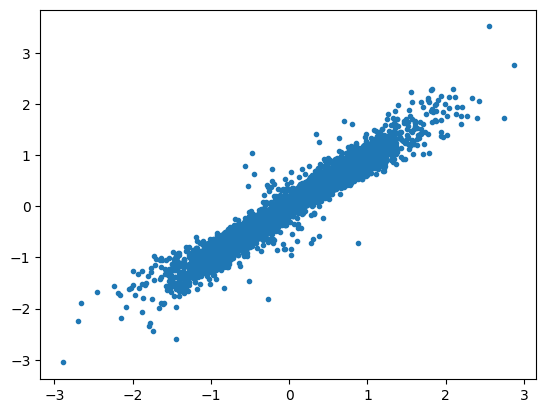

In [43]:
print((f_list[0] - f_list[1]).std())
plt.plot(f_list[0].flatten(), f_list[1].flatten(), '.')